# **HILLOVA ŠIFRA**
### Delovanje in teorija za šifriranje
Za boljše razumevanje so potrebne osnove zgoraj omenjenega načina šifriranja. Vsaka črka **angleške abecede** je bijektivno preslikana v elemente množice ostankov pri deljenju naravnih števil s številom **26**, torej s številom črk v abecedi. Števila si lahko predstavljamo, kot da so označena z indeksi od 0 do 25.

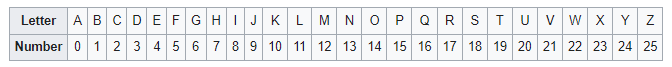

Blok črk **dolžine n** uporabimo kot vektor števil, ki smo jih pridobili s preslikavo in ima tako **n elementov**. V našem primeru je specificirana **dolžina bloka 2**. 

Pri enkripciji si izberemo ključ, matriko velikosti **n** $\times$ **n**, oziroma v našem primeru **2** $\times$ **2**. Vektor nato z leve strani pomnožimo z matriko.
Pri izbiri matrike moramo biti pazljivi, saj za dekripcijo potrebujemo njen inverz. Zadosten in potreben pogej za obstoj **inverza** je **neničelna** determinanta. Ker število 26 ni praštevilo, imamo v grupi tudi **delitelje niča**. Determinanta torej ne sme biti deljiva z delitelji števila 26. To sta števili **2** in **13**. Ta dejstva bodo drastično zmanjšala število potrebnih poskusov, preden besedilo dešifriramo.

### Program za dešifriranje
Program deluje za dolžino bloka 2. 
Najprej nastavimo okolje za lažje razumevanje. 
Implementirali bomo **slovar**, ki preslika črko v število in obratno.

In [2]:
import numpy as np
from collections import Counter

file = open('input.txt', 'r') 
encrypted_text = file.readline()
file.close()
length = len(encrypted_text)
n = 2 # velikost bloka - mogoce so posplositve
mod = 26 # dolzina abecede - mogoce so posplositve

alphabet = 'abcdefghijklmnopqrstuvwxyz'
num = {alphabet[i]: i for i in range(mod)}
ltr = {i: alphabet[i] for i in range(mod)}

In [3]:
# sifriran tekst razdelimo v bloke velikosti n
blocks = [encrypted_text[i:i+n] for i in range(0, length, n)]

V članku, ki je bil podan na spletni učilnici, je jasno razvidno, da če razpišenmo problem kot linearni sistem enačb, lahko šifro razbijemo po **vrsticah**. 
Tako zmanjšamo število ključev, ki jih je potrebno testirati. Naredimo torej **iteracijo** po vseh možnih vektorjih velikosti **n**, ki imajo elemente iz grupe.
Tako dobimo **prvo črko** bloka in ne celega bloka. Prve črke iz vseh blokov zlepimo v **niz**. Niz za vsak možen vektor zapišemo v seznam. Kasneje bomo rezultate uporabili za konstrukcijo matrik.  

In [6]:
rows = {}

for first in range(mod):
    for second in range(mod):
        letters = ''
        key = [first, second]
        
        for block in blocks:
    
            vector = [num[block[0]], num[block[1]]]
            
            result = np.matmul(key, vector) % mod
            letters += ltr[result]
        
        rows[chisquare(letters)] = key

# ta implementacija dela za velikost bloka 2

Sedaj bomo za vsako možno vrstico matrike uporabili **Chi-Squared Statistic** metodo, da optimiziramo iskanje. Vsakemu nizu v seznamu bomo dodali oceno glede frekvenco črk, ki se v njem pojavijo. Najboljše opcije so tiste z najnižjo oceno. Ta metoda je izkoristi **frekvenčno analizo črk**. Pogledamo pojavitve vsake črke v nizu vsakega bloka in jih primerjamo s povprečno frekvenco črke v angleškem jezku, glede na dolžino stavka. Nato bomo uporabili le vrstice, ki imajo boljšo oceno.

In [5]:
frequency = {
    'a': 8.17,
    'b': 1.49,
    'c': 2.78,
    'd': 4.25,
    'e': 12.70,
    'f': 2.23,
    'g': 2.02,
    'h': 6.09,
    'i': 7.00,
    'j': 0.15,
    'k': 0.77,
    'l': 4.03,
    'm': 2.41,
    'n': 6.75,
    'o': 7.51,
    'p': 1.93,
    'q': 0.10,
    'r': 5.99,
    's': 6.33,
    't': 9.06,
    'u': 2.76,
    'v': 0.98,
    'w': 2.36,
    'x': 0.15,
    'y': 1.97,
    'z': 0.07 }

def chisquare(str):

    observed = dict(Counter(str))
    for char in alphabet:
        if char not in observed:
            observed[char] = 0

    score = 0
    for char in alphabet:
        # izracun frekvence glede na stevilo crk v besedilu
        expected = ((frequency[char]) * len(str)) / 100 
        score += pow((observed[char] - expected), 2) / expected

    return score

Sedaj lahko izberemo `best` najboljših opcij glede na oceno, ki smo jo dobili zgoraj. Šifrirano besedilo poskusimo dešifrirati samo z matrikami, ki so permutacija selekcioniranih vrstic. Najboljšo rešitev poiščemo tako, da spet ocenimo najmanjšo odstopanje od pričakovane frekvence črk v besedilu. Vidimo, da za izpis potrebujemo **0.1** sekunde, ali celo manj, saj bi lahko `best` nastavili še nižje.

**Opomba**: Optimizacija na tak način je odvisna od dolžine besedila. Če bi enkriptirali samo besedo "cryptography" bi za rezultat potrebovali `best` vsaj 150.

**Zanimivost**: Ko sem dešifrirala samo besedo "cryptography" sem za izračun najprej potrebovala skoraj minuto. Problem je bil v računanju determinante z Numpy. Ko sem determinanto zračunala tako, kot lahko vidimo spodaj, se je čas izvajanja zmanjšal za več kot polovico. 

In [7]:
def decipher(matrix, blocks):
    deciphered = ''
    for block in blocks:
        vector = [num[block[0]], num[block[1]]]
        result = np.matmul(matrix, vector) % mod
        deciphered += ltr[result.item(0)] + ltr[result.item(1)]
    return deciphered

In [8]:
keys = sorted(rows)
sorted_rows = {i: rows[i] for i in keys}

solutions = {}
best = 10 # lahko sami reguliramo!
for r1 in list(sorted_rows.values())[:best]:
    for r2 in list(sorted_rows.values())[:best]:

        matrix = np.matrix([r1, r2])
        det = matrix[0,0]*matrix[1,1] - matrix[0,1]*matrix[1,0]

        if det != 0 and (det % 13) != 0 and (det % 2) != 0:
            text = decipher(matrix, blocks)
            error = chisquare(text)
            solutions[error] = [r1, r2, text]   

keys = list(solutions.keys())
keys.sort(reverse = False)
sorted_solutions = {i: solutions[i] for i in keys}
_ = {print(sorted_solutions[i]) for i in keys} # matrix key is: [0,1] [15,18]

[[0, 1], [15, 18], 'cryptographypriortothemodernagewaseffectivelysynonymouswithencryptiontheconversionofinformationfromareadablestatetoapparentnonsensetheoriginatorofanencryptedmessagealicesharedthedecodingtechniqueneededtorecovertheoriginalinformationonlywithintendedrecipientsbobtherebyprecludingunwantedpersonsevefromdoingthesamethecryptographyliteratureoftenusesaliceaforthesenderbobbfortheintendedrecipientandeveeavesdropperfortheadversarysincethedevelopmentofrotorciphermachinesinworldwariandtheadventofcomputersinworldwariithemethodsusedtocarryoutcryptologyhavebecomeincreasinglycomplexanditsapplicationmorewidespread']
[[13, 1], [15, 18], 'prlptotrnphycrioetbthemodeenagewasrffeptvvrlyslnbnymouswvthencryctioathecoavrrsibnbfvnformntioafromarendnbleftntrtoacpnrrngnbnsensrthebrigvnntbrbfnnrnprlptedmessagenliceshareqthedecodingtephniqurneedeqtbrecbvrrgheoriginaliafbrmatibnbnlywighvnteadrdrecipirntsbootherebycrecludinghnwaatrdpersbnsevesromdovntthesameghecryctograchllvtrrnthreostrnusesnlicea

## Solution
Cryptography prior to the modern age was effectively synonymous with encryption the conversion of information from areadable state to apparent nonsense. The originator of an encrypted message Alice shared the decoding technique needed to recover the original in formation only with intended recipients Bob thereby precluding unwanted persons Eve from doing the same. The cryptography literature often uses Alice A for the sender Bob B for the intended recipient and Eve eavesdropper for the adversary. Since the development of rotor cipher machines in World War I and the advent of computers in World War II the methods used to carry out cryptology have become increasingly complex and its application more widespread.